In [1]:
from fenics import *
from dolfin_adjoint import *
import pygmsh_mesh_functions
from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def hole_NPR(domain, c, l, theta, margin = 0.05):
    co, so = np.cos(theta), np.sin(theta)
    Rotation = np.array(((co, -so), (so, co)))
    shift_l = np.matmul(Rotation,np.array([-1,0]))
    shift_r = np.matmul(Rotation,np.array([ 1,0]))
    ell_c = add_ellipse(c, (1-margin)*np.sqrt(1/2)*l, (1-margin)*np.sqrt(1/2)*l)
    ell_l = add_ellipse(c+shift_l*l, (1+margin)*np.sqrt(1/2)*l, (1+margin)*np.sqrt(1/2)*l)
    ell_r = add_ellipse(c+shift_r*l, (1+margin)*np.sqrt(1/2)*l, (1+margin)*np.sqrt(1/2)*l)
    tool = subtract(ell_c, ell_l)
    tool = subtract(tool, ell_r)
    domain = subtract(domain, tool)

Info    : Running '/home/fenics/.local/bin/gmsh -3 /tmp/tmpagzbfsv4.geo -format msh -bin -o /tmp/tmph3koev73.msh' [Gmsh 4.9.5, 1 node, max. 1 thread]
Info    : Started on Mon Apr 25 02:15:14 2022
Info    : Reading '/tmp/tmpagzbfsv4.geo'...
Info    : Done reading '/tmp/tmpagzbfsv4.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 6077 (Ellipse)
Info    : [ 10%] Meshing curve 6078 (Ellipse)
Info    : [ 10%] Meshing curve 6079 (Ellipse)
Info    : [ 10%] Meshing curve 6080 (Ellipse)
Info    : [ 10%] Meshing curve 6081 (Ellipse)
Info    : [ 10%] Meshing curve 6082 (Line)
Info    : [ 10%] Meshing curve 6083 (Line)
Info    : [ 10%] Meshing curve 6084 (Line)
Info    : [ 10%] Meshing curve 6085 (Line)
Info    : [ 10%] Meshing curve 6086 (Ellipse)
Info    : [ 10%] Meshing curve 6087 (Ellipse)
Info    : [ 10%] Meshing curve 6088 (Ellipse)
Info    : [ 10%] Meshing curve 6089 (Ellipse)
Info    : [ 10%] Meshing curve 6090 (Ellipse)
Info    : [ 10%] Meshing curve 6091 (Ellipse)
Info    : [ 

3369

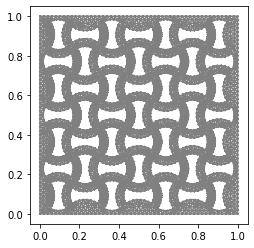

In [6]:
reset_geometry()

Lx = 1
Ly = 1

meshsize_min = 0.008
meshsize_max = 0.02

pygmsh_mesh_functions.hmeshmin = meshsize_min
pygmsh_mesh_functions.hmeshmax = meshsize_max

domain = add_polygon([(0, 0), (Lx, 0), (Lx, Ly), (0, Ly)])
X0 = np.array([0, 0])

#OPERATIONS ON DOMAIN
n_holes_x = 7
n_holes_y = 7
max_n_holes = np.max((n_holes_x,n_holes_x))
scale = 0.95

xx = scale*(np.arange(n_holes_x)-n_holes_x/2+0.5)/max_n_holes+0.5
yy = scale*(np.arange(n_holes_y)-n_holes_y/2+0.5)/max_n_holes+0.5
cx,cy = np.meshgrid(xx,yy)
cx = cx.reshape(n_holes_x*n_holes_y)
cy = cy.reshape(n_holes_x*n_holes_y)
c = np.vstack((cx,cy))

s_xx = (-1)**np.arange(n_holes_x)
s_yy = (-1)**np.arange(n_holes_y)
sgn_x,sgn_y = np.meshgrid(s_xx,s_yy)
sgn = sgn_x*sgn_y
sgn = sgn.reshape(n_holes_x*n_holes_y)
theta = np.pi*(1-sgn)/4

l = scale/max_n_holes

for i in range(len(theta)):
    hole_NPR(domain, c[:,i], l, theta[i], margin = 0.2)

#CREATE AND STORE MESH
sample_name = "test_NPR.xdmf"
out_dir = pathlib.Path("output_files")
out_dir.mkdir(parents=True, exist_ok=True)
mesh = create_fenics_mesh(mesh_path = out_dir / sample_name, verbose=True)
cell_type = mesh.cell_name()
with create_XDMFFile(out_dir / sample_name) as xf:
    xf.write(mesh)
    
plot(mesh)
len(mesh.coordinates())